In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/DW assignment/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading

In [3]:
import pandas as pd
import glob

# Path to folder containing your CSVs
path = '/content/drive/My Drive/DW assignment/'

# Get list of all CSV files
csv_files = glob.glob(path + "*.csv")

# Loop through each CSV and print shape + head
for file in csv_files:
    df_temp = pd.read_csv(file)
    file_name = file.split('/')[-1]
    print(f"\n=== {file_name} ===")
    print(f"Shape: {df_temp.shape}")
    print("Columns:", list(df_temp.columns))
    print("Head:")
    print(df_temp.head(), "\n")



=== circuits_mod.csv ===
Shape: (79, 9)
Columns: ['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng', 'alt', 'url']
Head:
   circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Inte

In [4]:
# Load required datasets
results = pd.read_csv(path + 'results_mod.csv')
status = pd.read_csv(path + 'status_mod.csv')
constructors = pd.read_csv(path + 'constructors_mod.csv')
pit_stops = pd.read_csv(path + 'pit_stops_mod.csv')
drivers = pd.read_csv(path + 'drivers_mod.csv')
races = pd.read_csv(path + 'races_mod.csv')
circuits = pd.read_csv(path + 'circuits_mod.csv')

### Data Cleansing

In [5]:
# =============================
# 3A. Data Cleansing
# =============================

# Ensure correct data types for dates
drivers['dob'] = pd.to_datetime(drivers['dob'], errors='coerce')
races['date']  = pd.to_datetime(races['date'], errors='coerce')

# Fill missing status with placeholder before target creation
results = results.merge(status, on='statusId', how='left')
results['status'] = results['status'].fillna('unknown')

# Handle missing pit stop counts later after merge


### Data Wrangling

In [6]:
# =============================
# 3B. Data Wrangling / Feature Engineering
# =============================

# Create finish vs retirement flag
def finished_flag(x):
    return 1 if "Finished" in x or "Lap" in x else 0
results['finished_flag'] = results['status'].apply(finished_flag)

# Merge constructor names
results = results.merge(constructors[['constructorId','name']], on='constructorId', how='left')
results.rename(columns={'name':'constructor_name'}, inplace=True)

# Aggregate pit stops
pit_stop_counts = pit_stops.groupby(['raceId','driverId']).size().reset_index(name='pit_stop_count')
results = results.merge(pit_stop_counts, on=['raceId','driverId'], how='left')
results['pit_stop_count'] = results['pit_stop_count'].fillna(0).astype(int)

# Calculate driver age at race
driver_race = results[['raceId','driverId']].drop_duplicates()
driver_race = driver_race.merge(drivers[['driverId','dob']], on='driverId', how='left')
driver_race = driver_race.merge(races[['raceId','date']], on='raceId', how='left')
driver_race['age_at_race'] = (driver_race['date'] - driver_race['dob']).dt.days / 365
results = results.merge(driver_race[['raceId','driverId','age_at_race']], on=['raceId','driverId'], how='left')
results['age_at_race'] = results['age_at_race'].fillna(results['age_at_race'].mean())

# Add race year
results = results.merge(races[['raceId','round','date']], on='raceId', how='left')
results['race_year'] = results['date'].dt.year

# Final feature set for Model 2
final_df = results[['grid','pit_stop_count','constructor_name','age_at_race','race_year','finished_flag']]
final_df = pd.get_dummies(final_df, columns=['constructor_name'], drop_first=True)


### Data Exploration

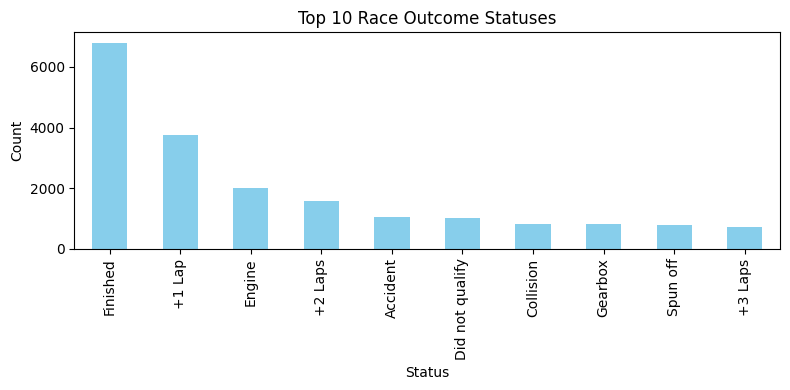

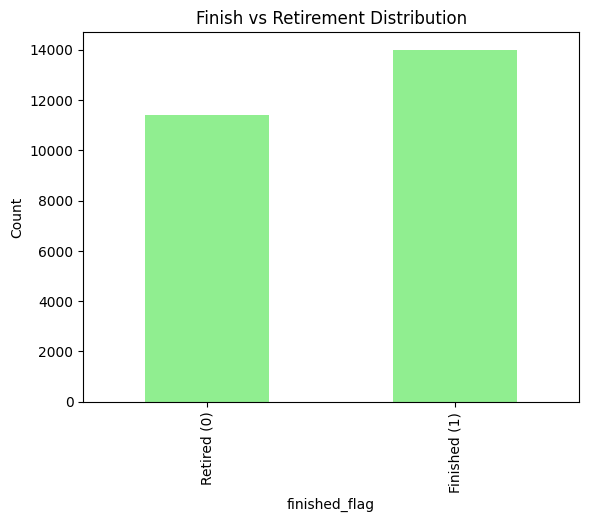

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 1. Status Distribution
# =============================
status_counts = results['status'].value_counts().head(10)
plt.figure(figsize=(8, 4))
status_counts.plot(kind='bar', color='skyblue')
plt.title("Top 10 Race Outcome Statuses")
plt.ylabel("Count")
plt.xlabel("Status")
plt.tight_layout()
plt.show()

# =============================
# 2. Finish vs Retirement
# =============================
final_df['finished_flag'].value_counts().sort_index().plot(
    kind='bar', color='lightgreen'
)
plt.xticks([0, 1], ['Retired (0)', 'Finished (1)'])
plt.title("Finish vs Retirement Distribution")
plt.ylabel("Count")
plt.show()


### Splitting

In [8]:
# =============================
# 5. Prepare Data for Modeling
# =============================
X = final_df.drop('finished_flag', axis=1)
y = final_df['finished_flag']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dataset summary
print("Final dataset shape:", final_df.shape)
print("Number of races:", results['raceId'].nunique())
print("Number of drivers:", results['driverId'].nunique())
print("Number of constructors:", results['constructorId'].nunique())
print("Total rows in results:", results.shape[0])


Final dataset shape: (25399, 214)
Number of races: 1057
Number of drivers: 853
Number of constructors: 210
Total rows in results: 25399


### Baseline Model

In [9]:
# =============================
# Baseline Model (Naïve)
# =============================
# Predict the most frequent class: 1 (Finished)
y_pred_baseline = np.ones_like(y_test)

# Evaluate baseline
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_prec = precision_score(y_test, y_pred_baseline)
baseline_rec = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print("Baseline Model (Always Predict Finished):")
print("Accuracy:", baseline_acc)
print("Precision:", baseline_prec)
print("Recall:", baseline_rec)
print("F1 Score:", baseline_f1)


Baseline Model (Always Predict Finished):
Accuracy: 0.5511811023622047
Precision: 0.5511811023622047
Recall: 1.0
F1 Score: 0.7106598984771574


### Model 2 (Exploratory and Post race)

In [10]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\nDecision Tree Results")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))




Decision Tree Results
Accuracy: 0.6643700787401575
Precision: 0.6921726921726922
Recall: 0.7042857142857143
F1 Score: 0.6981766684368915
Confusion Matrix:
 [[1403  877]
 [ 828 1972]]


### Feature Importance

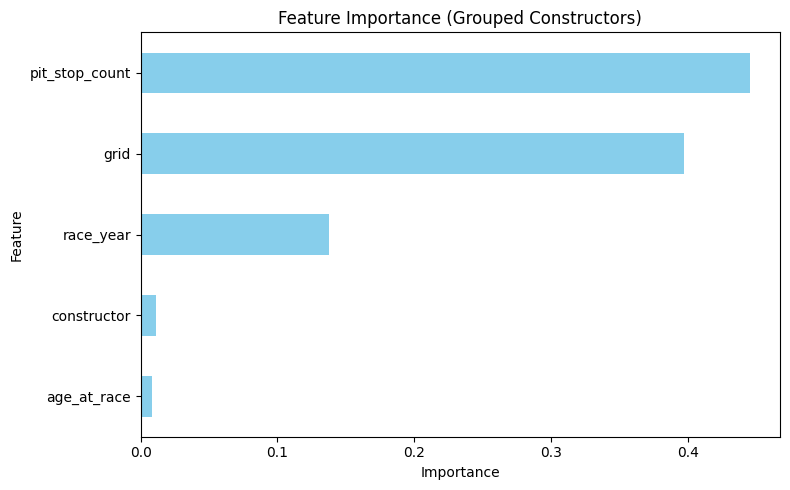

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances as a Series
feature_importances = pd.Series(dt.feature_importances_, index=X.columns)

# Combine all constructor dummy variables into one "constructor" category
constructor_cols = [col for col in feature_importances.index if col.startswith('constructor_name_')]
constructor_importance = feature_importances[constructor_cols].sum()

# Drop individual constructor dummies and add grouped value
feature_importances = feature_importances.drop(constructor_cols)
feature_importances['constructor'] = constructor_importance

# Sort and plot
feature_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance (Grouped Constructors)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Insights

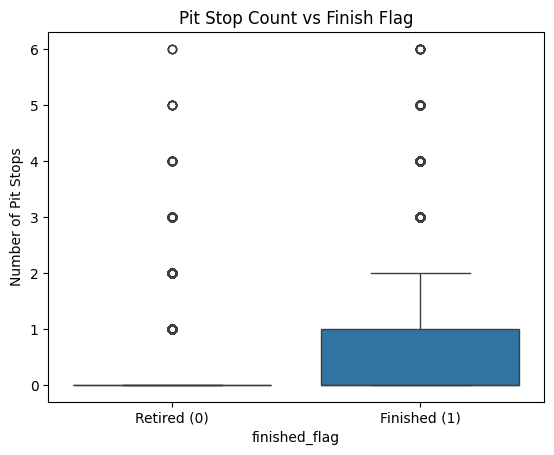

In [12]:
sns.boxplot(x='finished_flag', y='pit_stop_count', data=final_df)
plt.title("Pit Stop Count vs Finish Flag")
plt.xticks([0, 1], ['Retired (0)', 'Finished (1)'])
plt.ylabel("Number of Pit Stops")
plt.show()


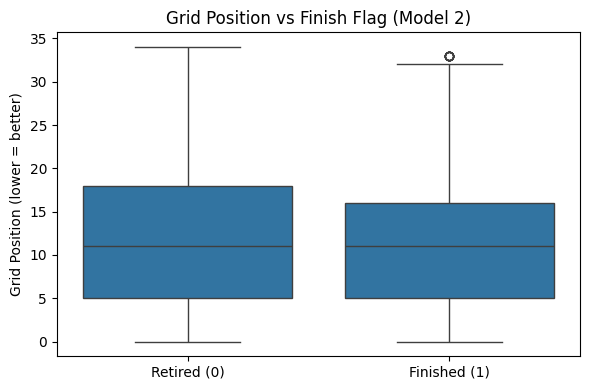

In [19]:
# =============================
# Visual: Grid Position vs Finish Flag (Model 2)
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(data=final_df, x='finished_flag', y='grid')
plt.xticks([0, 1], ['Retired (0)', 'Finished (1)'])
plt.ylabel('Grid Position (lower = better)')
plt.xlabel('')
plt.title('Grid Position vs Finish Flag (Model 2)')

plt.tight_layout()
plt.show()


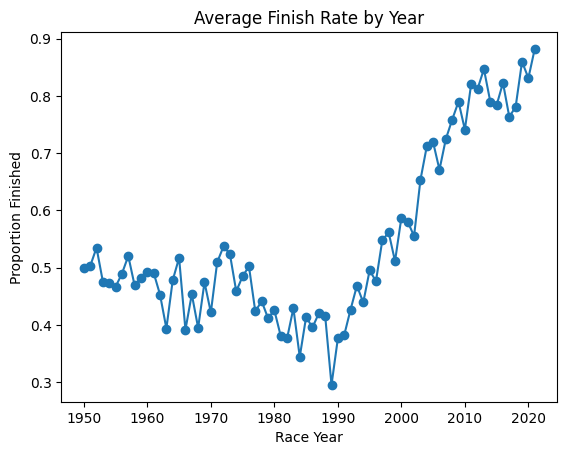

In [13]:
yearly_rate = final_df.groupby('race_year')['finished_flag'].mean()
yearly_rate.plot(kind='line', marker='o')
plt.title("Average Finish Rate by Year")
plt.ylabel("Proportion Finished")
plt.xlabel("Race Year")
plt.show()


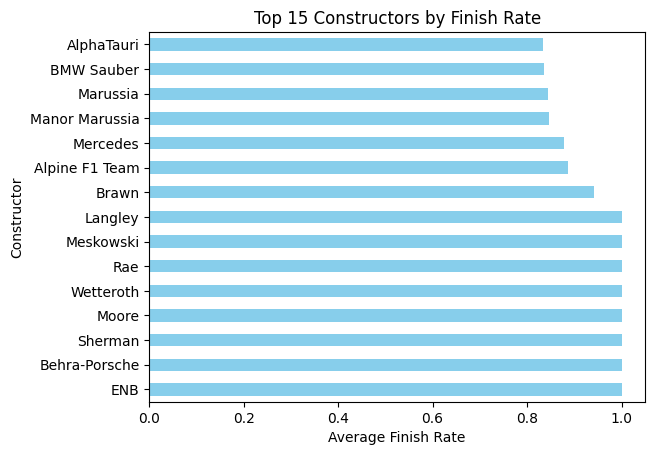

In [14]:
constructor_reliability = results.groupby('constructor_name')['finished_flag'].mean()
top_constructors = constructor_reliability.sort_values(ascending=False).head(15)
top_constructors.plot(kind='barh', color='skyblue')
plt.title("Top 15 Constructors by Finish Rate")
plt.xlabel("Average Finish Rate")
plt.ylabel("Constructor")
plt.show()


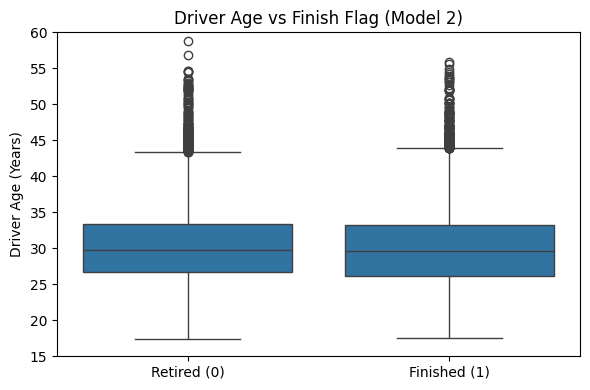

In [20]:
# =============================
# Visual: Driver Age vs Finish Flag (Model 2)
# =============================
plt.figure(figsize=(6,4))
sns.boxplot(data=final_df, x='finished_flag', y='age_at_race')
plt.xticks([0, 1], ['Retired (0)', 'Finished (1)'])
plt.ylabel('Driver Age (Years)')
plt.xlabel('')
plt.title('Driver Age vs Finish Flag (Model 2)')
plt.ylim(15, max(60, int(final_df['age_at_race'].max()) + 1))  # match scale
plt.tight_layout()
plt.show()


## Model 3 — True Pre-Race Decision Tree (Deployment-Ready)
Pre-race only features (grid, driver age at race, constructor, circuit, historical driver DNF rate). Train on past seasons, test on most recent season.


### Data Cleansing

In [12]:
# =============================
# 6A. Data Cleansing (True Pre-Race Features)
# =============================
import re

# --- Find & normalize the race date column in `races` ---
# prefer exact 'date', else try common variants or anything containing 'date'
race_date_candidates = [c for c in races.columns if c.lower() == 'date']
if not race_date_candidates:
    race_date_candidates = [c for c in races.columns if c.lower() in ('race_date','racedate','date_x','date_y')]
if not race_date_candidates:
    race_date_candidates = [c for c in races.columns if 'date' in c.lower()]

if not race_date_candidates:
    raise KeyError("Could not find a race date column in `races`. Columns: " + ", ".join(races.columns))

race_date_col = race_date_candidates[0]
races['date'] = pd.to_datetime(races[race_date_col], errors='coerce')

# ensure drivers dob is datetime
drivers['dob'] = pd.to_datetime(drivers['dob'], errors='coerce')

# add 'year' to races if missing
if 'year' not in races.columns:
    races['year'] = races['date'].dt.year



### Data Wrangling (True Pre Race Features)

In [13]:
# =============================
# 6B. Data Wrangling (True Pre-Race Features)
# =============================

# Merge only pre-race available information
base = results.merge(
    races[['raceId','year','round','date','circuitId']],
    on='raceId', how='left'
)
base = base.merge(drivers[['driverId','dob']], on='driverId', how='left')
base = base.merge(constructors[['constructorId','name']], on='constructorId', how='left')
base.rename(columns={'name':'constructor_name'}, inplace=True)
base = base.merge(circuits[['circuitId']], on='circuitId', how='left')

# --- Coalesce any date suffixes just in case and ensure datetime ---
if 'date' not in base.columns or base['date'].isna().all():
    cand = [c for c in base.columns if re.fullmatch(r'date(_x|_y)?', c, flags=re.I) or 'date' in c.lower()]
    # pick the first non-empty candidate
    picked = None
    for c in cand:
        if base[c].notna().any():
            picked = c
            break
    if picked is None:
        raise KeyError("No usable race date column found in merged `base`. Columns: " + ", ".join(base.columns))
    base['date'] = base[picked]

base['date'] = pd.to_datetime(base['date'], errors='coerce')
base['dob']  = pd.to_datetime(base['dob'],  errors='coerce')

# Calculate driver age at race
base['driver_age'] = (base['date'] - base['dob']).dt.days / 365.0

# Create DNF target (1 = retire, 0 = finish)
base['dnf_flag'] = 1 - base['finished_flag']

# Historical driver DNF rate up to previous race (no leakage)
tmp = base.sort_values(['driverId','date'])
g = tmp.groupby('driverId')
cum_dnfs = g['dnf_flag'].cumsum()
prior_n  = g.cumcount()
tmp['driver_dnf_rate_to_date'] = np.where(
    prior_n == 0, np.nan, (cum_dnfs - tmp['dnf_flag']) / prior_n
)
base = tmp

# Select pre-race features only
pre_cols = ['dnf_flag','year','raceId','driverId','constructorId','circuitId','grid','driver_age','driver_dnf_rate_to_date']
pre = base[pre_cols].dropna(subset=['year','grid','driver_age']).copy()

# One-hot encode categorical IDs
X3 = pd.get_dummies(
    pre[['grid','driver_age','driver_dnf_rate_to_date','constructorId','circuitId']].astype({'constructorId':int,'circuitId':int}),
    columns=['constructorId','circuitId'],
    drop_first=True
)
y3 = pre['dnf_flag'].astype(int)


### Model 3 Training and Evaluation (True Pre Race Decision Tree)

In [14]:
# =============================
 #Model Training & Evaluation (True Pre-Race Decision Tree)
# =============================

# Time-based split: past seasons → train, most recent season → test
last_year = int(pre['year'].max())
train_idx = pre['year'] < last_year
test_idx  = pre['year'] == last_year

X3_train, X3_test = X3[train_idx], X3[test_idx]
y3_train, y3_test = y3[train_idx], y3[test_idx]

print(f"Train years: {sorted(pre.loc[train_idx,'year'].unique())}")
print(f"Test year: {last_year}")
print("Train size:", X3_train.shape, " Test size:", X3_test.shape)

# Decision Tree model
dt3 = DecisionTreeClassifier(max_depth=5, random_state=42)
dt3.fit(X3_train, y3_train)
y3_pred = dt3.predict(X3_test)

# Performance metrics
print("\nTrue Pre-Race Decision Tree Results (Most Recent Season as Test)")
print("Accuracy:", accuracy_score(y3_test, y3_pred))
print("Precision:", precision_score(y3_test, y3_pred, zero_division=0))
print("Recall:", recall_score(y3_test, y3_pred, zero_division=0))
print("F1 Score:", f1_score(y3_test, y3_pred, zero_division=0))

# Top feature importances
imp = pd.Series(dt3.feature_importances_, index=X3_train.columns).sort_values(ascending=False).head(10)
print("\nTop features:\n", imp)



Train years: [np.float64(1950.0), np.float64(1951.0), np.float64(1952.0), np.float64(1953.0), np.float64(1954.0), np.float64(1955.0), np.float64(1956.0), np.float64(1957.0), np.float64(1958.0), np.float64(1959.0), np.float64(1960.0), np.float64(1961.0), np.float64(1962.0), np.float64(1963.0), np.float64(1964.0), np.float64(1965.0), np.float64(1966.0), np.float64(1967.0), np.float64(1968.0), np.float64(1969.0), np.float64(1970.0), np.float64(1971.0), np.float64(1972.0), np.float64(1973.0), np.float64(1974.0), np.float64(1975.0), np.float64(1976.0), np.float64(1977.0), np.float64(1978.0), np.float64(1979.0), np.float64(1980.0), np.float64(1981.0), np.float64(1982.0), np.float64(1983.0), np.float64(1984.0), np.float64(1985.0), np.float64(1986.0), np.float64(1987.0), np.float64(1988.0), np.float64(1989.0), np.float64(1990.0), np.float64(1991.0), np.float64(1992.0), np.float64(1993.0), np.float64(1994.0), np.float64(1995.0), np.float64(1996.0), np.float64(1997.0), np.float64(1998.0), np.flo

### Feature importance for Model 3

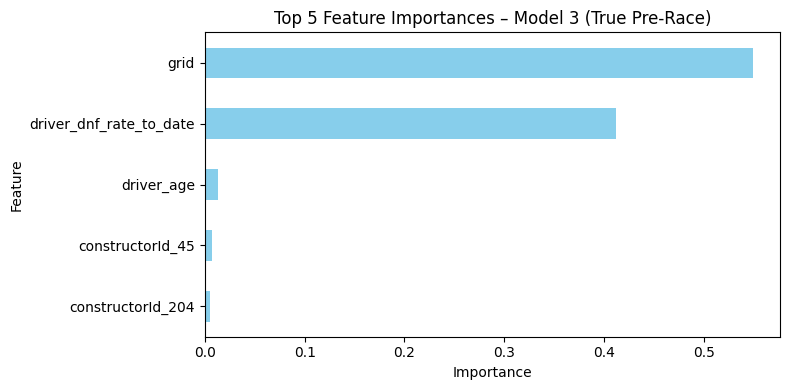

In [15]:
# =============================
# Visual: Top 5 Feature Importances (Model 3)
# =============================
top5 = imp.head(5)  # take only the top 5

top5.plot(kind='barh', figsize=(8,4), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances – Model 3 (True Pre-Race)')
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


# Report

## Tables of Content

**Introduction**



---


Help provide the context and background of Formula 1 (F1) racing, the different datasets used and overall project objectives. There is also outline of process of developing problem statement from the initial data exploration to a refined pre-race prediction model.


**Problem Formulation (Initial)**


---




This section enables the exploration of the F1 dataset and includes merging key datasets to create a finished_flag binary variable. There is also description on the findings from the Finish vs Retirement distribution as well as Top 10 race outcome statuses which helped highlight the frequent and diverse retirements. The insights gained led to the initial problem statement which focuses on analysing factors that influence retirement.


**Data Wrangling on Multiple tables**


---




Describes how I used to join methods to join the different tables based on foreign key of each table. I then also removed certain irrelevant columns that I did not need which helps save time in terms of model training and reduces noise as well.


**Data Cleansing and Transformation**


---




Describes how I applied different cleaning methods such as imputation of missing values and encoding on categorical variables. I also standardized the date format and verified the different data types.


**Machine Learning models**


---




Model 1- Baseline model:


This baseline model was built solely on predicting races that finished. This model was built to serve as a benchmark for evaluating other models.


Model 2 - Exploratory analysis and Initial decision tree model:


This model uses all available features which include pre-race and in-race data like pit stops to help identify key factors that influence race completion. Useful for post- race analysis but unsuited for pre-race prediction due to in-race data leakage.


 Model 3 - Refined Problem: True Pre-race Decision Tree model:


This is a refined model which uses only pre-race features for real world deployment, avoiding in-race data leakage.


**Summary and Further improvements:**


---




Recap of findings from models as well as the different limitations. There could also be potential improvements for future work such as incorporating weather data, improving the class balance as well as testing other algorithms.



## Introduction with Value Based problem statement

**Context and Importance:**



---


Formula 1 (F1) is one of the most demanding, popular and yet high-stakes motorsports in the world as cars are pushed to their mechanical limits while drivers are pushed to their physical limits. Most of them, if not all constructor teams would like their teams to win and to even stand a chance on winning, they must finish the race. However, F1 racers often see drivers unable to complete due to accidents or other mechanical issues. This leads to points being lost, wasted mechanical resources as well as potential safety risks to the driver. Therefore, predicting DNFs can help improve driver safety and cost efficiency as well as help in strategic planning.


**Dataset Overview:**


---




For this problem, I used multiple related tables like race, results, drivers, constructors, circuits, and pitstops. These datasets contained both pre-race information like grid position, driver age and constructor as well as in-race information like pit stops and lap times.


**Initial problem statement:**


---





Therefore, I came up with the initial problem statement:


**“Analysing factors that influence whether a car finishes or retires from a race, to understand key contributors to crashes and mechanical failures.”**

 Which essentially focuses more on identifying the key contributors to DNF races such as starting grid position, constructor reliability, drivers experience as well as pit stop frequency.

 The goal of this is to generate key insights that can be used for engineering improvement as well as help optimise race strategy.



**Value of the problem:**


---




With these insights, teams can help identify the high-risk conditions to reduce accidents. Moreover, it can also help support team strategy by adjusting qualifying and starting strategies that can help reduce retirement risk.

 The engineering team can also compare the differences between the different constructors’ teams to help better allocate resources to improve the car.

 Furthermore, we can conduct historical trend analysis to verify if safety and engineering regulations added helped decrease retirement rate. With less retirements, the races will become more competitive, and sponsors will put in more money which lead to commercial benefits.


**Limitations of the initial approach:**



---


While the initial decision tree model (Model 2) successfully identified key factors influencing retirements, it relied on in-race features such as pit stop counts and fastest lap times that are not available during pre-race. Hence, this model may only be used for post-race analysis and insight generation.



**Refined Problem Statement – True Pre Race Model**


---




Therefore, to address these limitations, I developed a True Pre-race decision tree model (Model 3) which uses only pre-race features that are available before the race actually starts (driver age, constructor, circuit, grid position as well as historical retirement rate).

This removes the in-race leakage, making it suitable for pre-race deployment and it aligns with the goal of predicting retirements before lights out so teams can help make strategic decisions.


## Problem Formulation

**Loading and Exploring the Data**

---





For my data exploration, I imported all of the csv files from the dataset given and printed the column head values, shapes and columns. This allows me to view the different values a certain dataset contain which allows me to plan out what kind of data wrangling methods should be used for different datasets and also to understand the structure and data available.


Even though there was a dictionary which tells us how each dataset is linked to each other, printing out the datasets allow me to easily visualise and plan how the tables can be linked for analysis.


**Understanding the Data**



---


After loading the dataset, I then began exploring the distribution of important variables, starting with race outcomes. To analyse the race outcomes, I merged the relevant datasets which were results, status and races using their foreign keys.


This would enable me to create the finished_flag binary variable which helped indicate if driver finished (1) or retired (0) in a race.


With this combined dataset, I then went ahead to plot the Finish vs Retirement distribution and found that retirements occurred at a surprisingly high rate. This served as a good opportunity for me to explore further on the statuses.

To further understand outcomes better, I then went ahead to plot the top 10 race outcome statuses and could infer that engine, accidents and collisions are top few race outcomes which emphasise that retirement in races is frequent and diverse in cause, making it worth and meaningful investigating.


**Formulating a Prediction Problem**



---


Therefore, based on my observations from the exploratory analysis, I developed my initial problem statement which was:


**“Analysing factors that influence whether a car finishes or retires from a race, to understand key contributors to crashes and mechanical failures.”**


Essentially, the aim was to identify influential variables like starting grid position, constructor reliability, driver’s age as well as pit stop frequency which helps to generate insights for future engineering improvement and race strategy.


However, the first predictive model (Model 2 – Initial Decision Tree) included data from both in-race and pre-race which made it only useful for post-race analysis but not suited for real-world deployment predictions.



Therefore, to address this limitation, I refined the problem into a True Pre-Race Model (Model 3) which only uses data in pre-race like drivers age, constructor, circuit, grid position as well as historical retirement rate.


This approach removes in-race leakage and aligns with the goals of predicting retirements before lights out, enabling actionable decisions during race predictions.



## Data Wrangling on Multiple Tables

**Objective:**


For this process, I combined multiple related F1 datasets into one single table for analysis and for modelling. I also had to make sure relevant information is connected using the correct foreign keys and remove irrelevant columns to reduce noise.


**Data wrangling for Model 2 – Initial Decision tree**


---


Steps taken:


1. **Identifying key tables to merge**


I selected the most relevant tables for the prediction problem which were:


Results, drivers IDs, constructors IDs, position, points and status IDs


**Reasons for each table:**


Results: Used the race outcome data

Races: Used the race date, season year and round

Drivers: Used the driver details like date of birth

Constructors - constructor details

Status- Shows the outcome reasons


2. **Merge datasets**

Joined results with status (with foreign key statusId) to get the descriptive race outcomes

Joined results with race (with foreign key raceId) to get the race date, year and round

Joined results with drivers (with foreign key driverId) to get date of birth of driver

Joined results with constructors (with foreign key constructorId) to get constructor name


3. **Error detection and correction:**

To ensure merge integrity, I validated joins and found out that using only raceId creates duplicates. So, I corrected this by joining on both raceId and driverId as composite keys which ensures each row uniquely represented a driver in one race.
Circuits table was not used for model 2

4. **Created target variable (finished_flag)**

Helps mark 1 if race if finished and 0 for retired



5. **Feature Engineering**


Created drivers age at race date as well as pit stop count as in-race performance features


6.	**Kept in-race features**
Kept variables like pit_stop_count and other race performance indicators so as to help identify the important features that influences race completion. Hence, in-race leakage is acceptable as this model is used for exploration for post-race analysis and not pre-race deployment.


**Data wrangling for Model 3 – True Pre-Race Decision Tree (Real World Deployment Model)**


---



**Objective:**


Help prepare a dataset with only pre-race variables so as to allow for predictions before the race starts, removing in-race data leakages.


**Steps taken:**


1. **Start from merged base:**


Used the same initial joins as model 2 for results, racers, drivers, constructors and status but merged with circuits (with foreign key circuitId) to include circuit information since it is a pre-race factor that can influence retirement which Model 2 did not consider.



2. **Removed in-race leakage columns:**


I dropped all columns that are known after the race begins like pit stop count, fastest lap time, laps, milliseconds and rank.
3. Feature Engineering:


I created column of driver age at race date similar to previous but also created historical retirement rate for each driver up to that race.  Moreover, also created grid position before start.


4. **Categorical and Numerical features (prepare for encoding, imputation and scaling):**


* Constructor ID (categorical)

* CircuitID (categorical)

* Grid position, driver age, historical retirement rate (numerical values)


**Purpose:**


Helps to avoid in-race leakage to ensure realistic pre-race predictions and make the model suited for real-world deployments before lights out.


## Data Cleaning and transformation

**Common Steps that are applied on both model:**


---



**Imputation:**


---



I also imputed missing status values with “unknown” before target creation


**Date standardisation:**


---


I parsed race dates and driver’s dates of birth to datetime type and calculated driver age at race
I also ensured IDs like raceId, driverId and constructorId are numerical values and joinable


**Target construction from joins:**


---



I joined results and status to obtain more description on outcomes and build a finish/retire target. Model 2 uses finished_flag while model 3 converts to a do not finish (DNF) target for pre-race prediction


**Join validation:**



---


I also verified the row counts after merges and checked keys to avoid accidental row loss or even any duplicated merged rows


**Column removal:**



---


I removed unused metadata like the URLS of Wikipedia and kept only columns that can bring predictive value to the model


**Scaling:**



---


No scaling was done for numerical value features as tree-based models do not require it


**Model 2 – Initial Decision Tree (Exploratory & post-race)**


**Merges + Target:**



---


Merged results + status to create finished_flag by a simple rule which is that if status contains “Finished” or “Lap” then = 1, else = 0

Merged results + constructors to add constructor_name

Merged results + races to add date, round and race_year

Calculated driver age by merging drivers DOB and races date

**Feature engineering:**



---


I also aggregated pit_stop_count values from pit_stops by raceId, driverId

I also imputed the missing pit_stop_count values with 0 as I am assuming that there are no stops recorded


I then went ahead to impute missing age_at_race with mean as it is a simple and transparent mode of imputation


**Encoding:**


I then conducted one-hot encoding on variables like constructor_name


**Final model table:**


['grid', 'pit_stop_count', 'constructor_name_*', 'age_at_race', 'race_year', 'finished_flag']


Circuit data was not used in Model 2

In-race features like pit_stop_count were used intentionally and is acceptable in this model as Model 2 is for a post-race exploration and factor discovery and not a pre-race deployment model



**Model 3 - True Pre-race Decision Tree (Deployment ready)**



---


**Merges + Target**


It uses the same base joins as Model 2 but includes circuits (merged through circuitId) to include pre-race circuit context


The target reframed to DNF (1 = retire, 0 = finish) for a pre-race risk prediction

**Removed leakage of using in-race data**

I removed all the in-race data such as:

* Laps

* Milliseconds

* Fastest lap time

* Fastest lap speed

* rank

**Pre-race features:**


I used grid position, driver’s age, constructor and circuit


I also created historical driver retirement rate computed with cumulative counts and shift() so that each row only uses information from earlier races in the same season


**Encoding:**
I conducted one-hot encoding on constructorId and circuitId (categoricals) and kept numerical values as it is since tree models do not require scaling


## Machine Learning Models




**Counts of Rows and Columns:**

**Model 2 – Initial Decision Tree**


**Data set after wrangling:** (25399, 214)

It contains both pre-race and in-race features like pit_stop_count

**Model 3 – True Pre-Race Decision Tree**

**Data set after wrangling:**(24,989, 287)

Contains only pre-race features like grid position, driver age, constructor, circuit and historical retirement rate

**Training and testing split based:**

Used past seasons as training set and most recent year as test set which helps to simulate a real-world deployment

**Naïve Baseline Model:**

**Purpose:**

Used as a minimum performance benchmark for comparison

**Evaluation:**

Accuracy: 0.5511811023622047

Precision: 0.5511811023622047

Recall: 1.0

F1 Score: 0.7106598984771574

**Interpretation:**


It always predicts the most common class which is “Finish, offers no predictive power for retirements

**Building of Model 2 – Initial Decision Tree** (Exploratory & post-race)

**Approach:** It uses both pre-race and in-race data to help identify key factors that affects race completion

**Evaluation Metrics:**

Accuracy: 0.6644

Precision: 0.6922

Recall: 0.7043

F1 Score: 0.6982

**Interpretation:**

It has a balanced precision and recall which indicates that the model can reasonably detect both finishers and retirements

It is also stronger than the baseline model created earlier which meant that race features helped add meaningful predictive value.

However, this model is unsuitable for pre-race deployment due to data leakage (uses in-race features)

**Building of Model 3 – True Pre-Race Decision Tree (Deployment-Ready)**

**Approach:**

Uses only pre-race features, with categorical encoding for constructor and circuit and numerical values like grid position and history retirement rate

**Time-based train and test:**

Used past seasons as training set and most recent year as test set which helps to simulate a real-world deployment since predictions must be made for future races without any access to future data


This also helps removes data leakage that could occur if random splitting allowed information from the future races to influence the model during training


**Evaluation Metrics:**

Accuracy: 0.8696

Precision: 0.2727

Recall: 0.0638

F1 Score: 0.1034

**Interpretation:**

The high accuracy reflects class imbalance since most predictions in recent season defaults to “Finish”


The low recall rate (6.38%) for retirements is due to the fact that retirements are rare events in the recent seasons which means that the model has very few positive examples to learn from.

Hence, while accuracy is high, it hides the fact that model struggles with rare but important events
However, this model still avoids leakage and is still realistic for a deployment


**Conclusion:**

Model 2 demonstrates a strong performance (predicts both retirement and finishes) but uses in-race data which makes it a post-race analysis tool only


Model 3 uses realistic pre-race setup but highlights the challenges of predicting rare retirement events in modern F1. This imbalance is further explored in next section through historical retirement trend analysis.


## Summary + Further improvements

**Summary of Findings:**

**Model 2 (Exploratory and Post race)**


It achieved a balanced performance and showed that both pre-race and in-race features contributed meaningfully to detect retirements.


**Feature importance shows that:**


**Pit stops (Most important):**

Cars that retire often have zero pit stops which suggests that cars experience mechanical failure or accidents before a scheduled pit stop

**Grid Position:**

Cars starting further back higher chances of retirement due to increased risk of collisions and overtaking incidents

**Race Year:**

Retirement rates dropped from ~0.5 in 1950s to ~0.1 in 2020s which shows that there is improved safety and reliability

**Constructor:**

Different teams have different engineering quality and reliability

**Driver age:**

Suggests that experience difference are not major factors

While this model is useful for post-race factor discovery, inclusion of in-race makes it unsuitable for pre-race deployment

**Model 3 (True Pre-Race Deployment)**


Only uses pre-race data and time-based split (trained on past seasons, test on most recent)


While it reached a high accuracy of 86.96%, it struggled with the recall for retirements (6.38%) due to retirements being rare and class imbalance in the recent years.

Although grid position and driver’s historical retirement rate had high feature importance, these features alone are not sufficient to capture rare retirement events.

This reflects a real-world deployment challenge which is predicting rare but impactful events.

**Potential benefits of the Models:**


**Model 2 – Post race tool**

Identifies key factors (e.g. pit stop patterns) that influences race completion

Enables engineers to highlight mechanical/strategic weaknesses as well as long term engineering improvements and reliability

**Model 3: Prerace risk assessment tool**

to identify higher-risk drivers or circuits which allow for strategic planning and resource allocation
Insights from both models can validate safety regulations, support strategic planning and increase commercial value since it can become more competitive.

**Strategic implications:**

Improve early race reliability to avoid pit stop failures and use defensive strategies for drivers at the back to decrease risk of collision

**Improvements for future:**

**Address class imbalance:**

Apply under sampling or SMOTE to help model see more examples of retirements, increasing recall for rare events

Add class – weight tuning to penalise missed retirements to make model more sensitive to retirements

**Feature expansion:**

Add historical constructor reliability rates, weather conditions (rain might increase retirement risk) and more detailed circuit characteristics

**Model Enhancements:**

Explore different ensemble models like Random Forest, Gradient boosting or even XGBoost to improve the rare event detection and accuracy

Can also explore hybrid approaches like combining statistical reliability models with machine learning predictions to improve prediction confidence
Conclusion

Overall, Model 2 provided valuable insights into the different factors that influences race outcomes while Model 3 offered a realistic deployment framework despite struggling with rare event detection.

Hence, future models should try to balance precision and recall which helps to ensure that even rare but important retirements are identified without compromising real-world applicability.



## Reflection

**What have I learnt that from this module and why do I feel it is useful?**

From this module, I learnt about the different data wrangling methods such the different encoding methods and scaling methods.

I also learn that by selecting relevant columns to train the model, we can help save time and efficiency as well as reduce noise. Moreover, data wrangling enables us to convert raw data into suitable data format can be processed by the model.

Nowadays, with AI being more and more prevalent, data wrangling also becomes more important since AI also requires some sort of data wrangling methods like lemmatization and tokenization.

I think it is very interesting how there are also many different data wrangling methods for a particular process. For example, there is min-max scaling and robust scaling etc and these methods can actually provide us with different results and we have to sort of conduct trial and error to know which methods are actually suitable for our dataset. 

 I think it is very useful as it is very important to feed good data quality to our models as the quality of our data can directly impact the performance of our model.

 Hence, if we clean the data well, the model will be able to learn better and perform better. I also think data wrangling process also serves as a baseline for all model building and if this step is not done properly, then it will impact the future processes and steps.

**Where can I apply the new knowledge and experience gained from this module?**

I believe that I can apply the new knowledge and experience for my future jobs as well as machine learning modules. In the field of data science, machine learning has become one of the most popular courses.

Hence, many employers are looking out for people who are able to clean data well and hence, for my future job, I think I would be able to apply data wrangling methods in those areas.

Moreover, in other modules like machine learning and deep learning, I have also applied data wrangling methods into these modules which shows how much of an importance and common and universal process data wrangling is.


**What surprised me the most during the module?**


I was surprised at how data wrangling is also required in other modules as usually I thought that most modules learnt separate processes so it will not be interlinked but I was surprised at how actually they are cross related. I find that to be very interesting as we can apply what we learn across the different modules.

Moreover, I also didn’t understand how data quality could impact the learning of our models until recently where I did both my deep learning model and realised that the data wrangling process actually affected the results of my models that I have built. Hence, I found that to be surprising.


**If I could redo the practical or assignment, what would I do differently and why?**


If I could redo the practical or assignment, I would wish to fully understand what I am doing in my practical. Sometimes, whenever I meet an issue in my code, I would find myself relying on ChatGPT or my friends to help me with my work.

I think that sort of cause the practical to lose their meaning as practical are provided for us to learn the different data wrangling methods and what not, but by using ChatGPT for some of the harder questions, I tend to lose out on the learning process since I am just doing it without understanding the concept and logic behind a certain code.

I think instead of just blindly using ChatGPT, I can also make use of ChatGPT to help me understand the codes and logic which can help aid my learning.


**What might have helped improve my learning process?**


I think overall, the learning process has been quite smooth since there are a lot of practical exercises that the teacher went through in class. However, sometimes I find myself finding certain concepts too complicated like the feature engineering process which was hard for me to understand.

So, I think what could have improved my learning process was maybe adding simpler examples that can help explain the harder concepts. These simpler examples can be seen in the earlier lectures which allowed me to understand the harder concepts which I really appreciate.

I think at the same time on my side, I could have made better use of AI to help me better understand the different codes applied which can help me gain a better foundation in this module. I think sometimes for the exams and quiz, it is easier to blindly remember than to understand difficult concepts like PCA which took me awhile to understand. Hence, I think taking time out to figure things out slowly to understand the different concepts would have solidify my learning in DW.

**How does the topic of Data Wrangling relate to the other modules I have taken so far?**


Like I said previously, I was actually surprised at how data wrangling is such an important step in modules like deep learning and machine learning where the methods we used to clean and scale our data can directly impact the model’s results.I did not expect myself to be conducting data wrangling in many of my modules. That actually shows how important data wrangling is and how it is a universal step before we built our models. Moreover, I think in future modules like Machine learning II, data wrangling will be even more important.


